
# Step 1: Pre-processing

Preprocess Sentence Function:

Numerical Value Handling:
Finds numerical values (integers and decimals).
Sorts these numbers and maps them to a sequence of numbers (1, 2, 3, ...).
Replaces the original numbers with their mapped values to reduce the vocabulary size and potential bias.

Financial Term Handling:
Replaces abbreviations like 'k', 'm', 'b', and 't' with their full forms (thousand, million, billion, trillion).
Handles monetary units like USD, EUR, etc., by rearranging the format to a more consistent one.

Special Character Removal:
Removes any characters that are not alphanumeric or whitespace.

Extra Space Removal:
Removes redundant whitespace characters.

Load and Preprocess Data:

Reads the CSV data into a pandas DataFrame.
Maps sentiment labels to numerical values for easier processing.
Applies the preprocess_sentence function to each sentence in the 'Sentence' column and stores the result in the 'Processed_Sentence' column.

In [12]:
import pandas as pd
import re
import spacy

# Load the SpaCy tokenizer
nlp = spacy.load("en_core_web_sm")

# Function to preprocess the sentence
def preprocess_sentence(sentence):
    # Step 1: Handle numerical values
    def replace_numerical_values(text):
        # Find all numerical sequences including decimals
        numbers = re.findall(r'\d+\.?\d*', text)
        # Sort numbers and map them to 1-9
        sorted_numbers = sorted(set(float(num) for num in numbers))
        number_mapping = {num: str(i + 1) for i, num in enumerate(sorted_numbers)}
        for num in numbers:
            text = text.replace(num, number_mapping[float(num)])
        return text

    # Step 2: Handle financial terms
    def replace_financial_terms(text):
        # Replace k, m, b, t with their full forms
        text = re.sub(r'(\d+)\s*[kK]', r'\1 thousand', text)
        text = re.sub(r'(\d+)\s*[mM]', r'\1 million', text)
        text = re.sub(r'(\d+)\s*[bB]', r'\1 billion', text)
        text = re.sub(r'(\d+)\s*[tT]', r'\1 trillion', text)
        # Handle monetary units
        text = re.sub(r'([A-Z]{3})\s*(\d+)', r'\2 \1', text)
        return text

    # Step 3: Remove special characters
    def remove_special_characters(text):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Step 4: Remove extra spaces
    def remove_extra_spaces(text):
        return re.sub(r'\s+', ' ', text).strip()

    # Apply the functions in order
    sentence = replace_numerical_values(sentence)
    sentence = replace_financial_terms(sentence)
    sentence = remove_special_characters(sentence)
    sentence = remove_extra_spaces(sentence)

    return sentence

# Load the data
data = pd.read_csv('assignment4_data.csv')

sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data['Sentiment'] = data['Sentiment'].map(sentiment_mapping)

# Preprocess the sentences
data['Processed_Sentence'] = data['Sentence'].apply(preprocess_sentence)

# Display the first few processed sentences
print(data[['Sentence', 'Processed_Sentence', 'Sentiment']].head())


                                            Sentence  \
0  The GeoSolutions technology will leverage Bene...   
1  $ESI on lows, down $1.50 to $2.50 BK a real po...   
2  For the last quarter of 2010 , Componenta 's n...   
3  According to the Finnish-Russian Chamber of Co...   
4  The Swedish buyout firm has sold its remaining...   

                                  Processed_Sentence  Sentiment  
0  The GeoSolutions technology will leverage Bene...          2  
1  ESI on lows down 1 trilliono 2 billionK a real...          0  
2  For the last quarter of 4 Componenta s net sal...          2  
3  According to the FinnishRussian Chamber of Com...          1  
4  The Swedish buyout firm has sold its remaining...          1  


# Step 2: Creating an embedding matrix


Load SpaCy Model and Word2Vec Model:

SpaCy: Loads a small English language model for basic NLP tasks.
Word2Vec: Loads a pre-trained Word2Vec model, which maps words to dense vectors.
Preprocess Sentences:

Similar to the previous code, this step cleans the text by handling numerical values, financial terms, special characters, and extra spaces.
Create Vocabulary and Embedding Matrix:

Vocabulary: Creates a mapping from words to unique integer indices.
Embedding Matrix: Initializes a matrix where each row corresponds to a word in the vocabulary, and the row values are the word's embedding vector from the Word2Vec model. For words not in the Word2Vec model, random embeddings are initialized.
Convert Sentences to Sequences of Indices:

Tokenizes each sentence using SpaCy.
Maps each token to its corresponding index from the vocabulary.
Pads sequences to a fixed length (max_length) for batch processing.
Convert Labels to One-Hot Vectors:

Converts sentiment labels (negative, neutral, positive) to numerical representations suitable for categorical classification.

In [12]:
import pandas as pd
import numpy as np
import re
import spacy
from gensim.models import KeyedVectors
import gensim.downloader as api
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the SpaCy tokenizer
nlp = spacy.load("en_core_web_sm")

# Load the Word2Vec Google News pre-trained model
print("Loading Word2Vec pre-trained model...")
word2vec_model = api.load('word2vec-google-news-300')


# Function to preprocess the sentence
def preprocess_sentence(sentence):
    # Step 1: Handle numerical values
    def replace_numerical_values(text):
        numbers = re.findall(r'\d+\.?\d*', text)
        sorted_numbers = sorted(set(float(num) for num in numbers))
        number_mapping = {num: str(i + 1) for i, num in enumerate(sorted_numbers)}
        for num in numbers:
            text = text.replace(num, number_mapping[float(num)])
        return text

    def replace_financial_terms(text):
        text = re.sub(r'(\d+)\s*[kK]', r'\1 thousand', text)
        text = re.sub(r'(\d+)\s*[mM]', r'\1 million', text)
        text = re.sub(r'(\d+)\s*[bB]', r'\1 billion', text)
        text = re.sub(r'(\d+)\s*[tT]', r'\1 trillion', text)
        text = re.sub(r'([A-Z]{3})\s*(\d+)', r'\2 \1', text)
        return text

    def remove_special_characters(text):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)

    def remove_extra_spaces(text):
        return re.sub(r'\s+', ' ', text).strip()

    sentence = replace_numerical_values(sentence)
    sentence = replace_financial_terms(sentence)
    sentence = remove_special_characters(sentence)
    sentence = remove_extra_spaces(sentence)

    return sentence

def create_vocabulary_and_embeddings(processed_sentences, word2vec_model):
    """
    Create vocabulary and embedding matrix from processed sentences
    """
    # Initialize vocabulary with sentence separator token
    vocabulary = {'</s>': 0}
    word_count = 1  # Start from 1 as 0 is reserved for </s>

    # First pass: create vocabulary
    for sentence in processed_sentences:
        doc = nlp(sentence)
        for token in doc:
            word = token.text
            # Only add words that exist in Word2Vec vocabulary
            if word not in vocabulary and word in word2vec_model:
                vocabulary[word] = word_count
                word_count += 1

    # Create embedding matrix
    vocab_size = len(vocabulary)
    embedding_dim = word2vec_model.vector_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Add word vectors to embedding matrix
    for word, idx in vocabulary.items():
        if word == '</s>':
            # Initialize sentence separator token with random values
            embedding_matrix[idx] = np.random.uniform(-0.25, 0.25, embedding_dim)
        else:
            embedding_matrix[idx] = word2vec_model[word]

    return vocabulary, embedding_matrix

def sentences_to_indices(processed_sentences, vocabulary, max_length):
    """
    Convert sentences to padded sequences of indices
    """
    sequences = []
    for sentence in processed_sentences:
        doc = nlp(sentence)
        sequence = []
        for token in doc:
            word = token.text
            # Use vocabulary index if word exists, else use 0 (</s>)
            idx = vocabulary.get(word, 0)
            sequence.append(idx)
        sequences.append(sequence)

    # Pad sequences to max_length
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
    return padded_sequences

# Load the data
data = pd.read_csv('assignment4_data.csv')

# Map sentiments to numerical values
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data['Sentiment'] = data['Sentiment'].map(sentiment_mapping)

# Preprocess the sentences
data['Processed_Sentence'] = data['Sentence'].apply(preprocess_sentence)

# Create vocabulary and embedding matrix
vocabulary, embedding_matrix = create_vocabulary_and_embeddings(data['Processed_Sentence'], word2vec_model)

# Find maximum sentence length
max_sentence_length = max(len(nlp(sentence)) for sentence in data['Processed_Sentence'])
max_length = max_sentence_length + 2  # Add 2 for padding

# Convert sentences to sequences of indices
X = sentences_to_indices(data['Processed_Sentence'], vocabulary, max_length)

# Convert labels to one-hot vectors
y = to_categorical(data['Sentiment'])

# Print some statistics
print(f"Vocabulary size: {len(vocabulary)}")
print(f"vocabulary: {vocabulary}")
print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Input sequence length: {max_length}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Loading Word2Vec pre-trained model...
Vocabulary size: 10873
vocabulary: {'</s>': 0, 'The': 1, 'GeoSolutions': 2, 'technology': 3, 'will': 4, 'leverage': 5, 'Benefon': 6, 's': 7, 'GPS': 8, 'solutions': 9, 'by': 10, 'providing': 11, 'Location': 12, 'Based': 13, 'Search': 14, 'Technology': 15, 'Communities': 16, 'Platform': 17, 'location': 18, 'relevant': 19, 'multimedia': 20, 'content': 21, 'new': 22, 'powerful': 23, 'commercial': 24, 'model': 25, 'ESI': 26, 'on': 27, 'lows': 28, 'down': 29, '1': 30, '2': 31, 'real': 32, 'possibility': 33, 'For': 34, 'the': 35, 'last': 36, 'quarter': 37, '4': 38, 'Componenta': 39, 'net': 40, 'sales': 41, 'doubled': 42, '3': 43, 'EUR': 44, 'million': 45, 'from': 46, 'for': 47, 'same': 48, 'period': 49, 'year': 50, 'earlier': 51, 'while': 52, 'it': 53, 'moved': 54, 'zero': 55, 'pretax': 56, 'profit': 57, 'loss': 58, 'According': 59, 'Chamber': 60, 'Commerce': 61, 'all': 62, 'major': 63, 'construction': 64, 'companies': 65, 'Finland': 66, 'are': 67, 'opera

Step 3: Neural networks:
The first step before you develop your ANN models is to check your labels to see if you have class imbalance or not. Plot the histogram of the labels.

Data Analysis and Preprocessing (Already Explained):

Analyzes sentiment class distribution using Seaborn.
Calculates class weights to address potential class imbalance (optional).
Splits the data into training and testing sets.
Callbacks:

Defines callbacks for early stopping, reducing learning rate based on validation loss, and restoring best weights.

1. Feed-Forward Neural Network (FFN) with Pre-trained Embeddings:

create_ffn_model function builds the FFN model.
Uses a pre-trained embedding matrix (frozen weights).
Embeds text sequences, applies global average pooling, and feeds into dense layers with activation and dropout.
Compiles the model with Adam optimizer, categorical cross-entropy loss, and accuracy metric.
Trains the FFN model with frozen embeddings.
Evaluates the FFN model and prints the classification report.

2. FFN with Fine-tuning Embeddings:

Similar to FFN with pre-trained embeddings, but the trainable argument is set to True in create_ffn_model to allow fine-tuning the embedding weights during training.
Trains the FFN model with fine-tuning embeddings.

3. Recurrent Neural Network (RNN) with FFN Classifier Head:

create_rnn_model function builds the RNN model.
Uses pre-trained embedding matrix (frozen weights).
Stacks multiple SimpleRNN layers with dropout for capturing sequential information in the text.
Adds an FFN head with dense layers, activation, dropout, and softmax output for classification.
Compiles the model with Adam optimizer, categorical cross-entropy loss, and accuracy metric.
Trains the RNN model.

4. Complex Bidirectional RNN:

create_complex_rnn_model function builds the complex RNN model.
Uses pre-trained embedding matrix (frozen weights).
Stacks multiple Bidirectional SimpleRNN layers with dropout, allowing the model to learn from both directions of the text sequence.
Similar FFN head as the RNN model.
Compiles the model with Adam optimizer, categorical cross-entropy loss, and accuracy metric.
Trains the complex RNN model.
Evaluation and Visualization:

Defines plot_training_history function to visualize training and validation accuracy/loss curves for all models.
Trains all models and plots their training history.
Evaluates each model on the test set and prints the classification report.

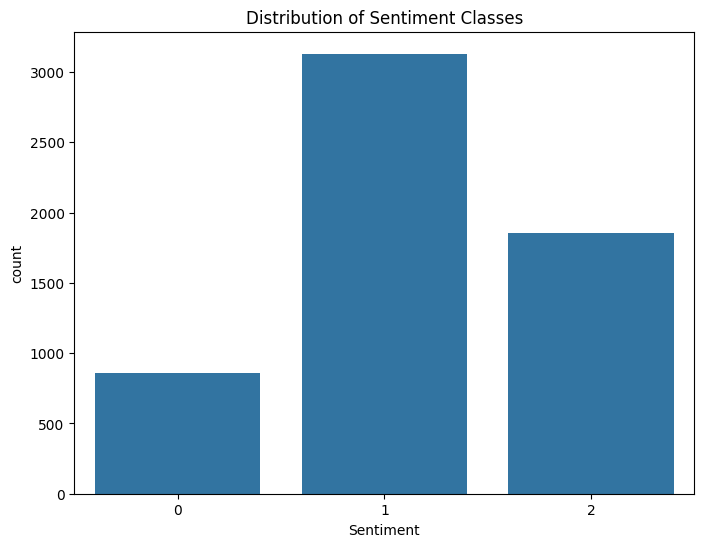

Class weights: {0: 0.6221512247071352, 1: 1.0514758819294456, 2: 2.264341085271318}

FFN Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ ?                           │       2,305,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_6           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,305,800 (8.80 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,305,800 (8.80 MB)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4474 - loss: 5.4895 - val_accuracy: 0.5219 - val_loss: 3.5046 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5705 - loss: 3.5932 - val_accuracy: 0.4995 - val_loss: 2.9104 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5957 - loss: 2.9300 - val_accuracy: 0.4011 - val_loss: 2.5138 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6052 - loss: 2.4560 - val_accuracy: 0.5551 - val_loss: 2.1542 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6394 - loss: 2.0960 - val_accuracy: 0.5455 - val_loss: 2.1169 - learning_rate: 0.0010
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6290 - loss: 1.8933 - val_accuracy: 0.4150 - val_loss: 1.9903 - learning_rate: 0.0010
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6510 - loss: 1.6327

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ ?                           │       2,305,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_7           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,305,800 (8.80 MB)

 Trainable params: 2,305,800 (8.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4415 - loss: 5.3181 - val_accuracy: 0.5027 - val_loss: 3.2193 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6259 - loss: 3.1483 - val_accuracy: 0.5262 - val_loss: 2.6928 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7341 - loss: 2.3123 - val_accuracy: 0.5198 - val_loss: 2.3109 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7875 - loss: 1.8065 - val_accuracy: 0.5305 - val_loss: 2.3919 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8194 - loss: 1.4363 - val_accuracy: 0.6620 - val_loss: 1.6446 - learning_rate: 0.0010

RNN Model Summary:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ ?                           │       2,305,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_18 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_19 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_20 (SimpleRNN)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,305,800 (8.80 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,305,800 (8.80 MB)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 30s 190ms/step - accuracy: 0.3508 - loss: 3.7620 - val_accuracy: 0.3412 - val_loss: 2.6280 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.3771 - loss: 3.0897 - val_accuracy: 0.3412 - val_loss: 2.4539 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.3883 - loss: 2.7511 - val_accuracy: 0.3412 - val_loss: 2.3947 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.3936 - loss: 2.5171 - val_accuracy: 0.3412 - val_loss: 2.1827 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.3907 - loss: 2.3183 - val_accuracy: 0.3412 - val_loss: 2.0292 - learning_rate: 0.0010

Complex RNN Model Summary:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ ?                           │       2,305,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,305,800 (8.80 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,305,800 (8.80 MB)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 381ms/step - accuracy: 0.3526 - loss: 4.2637 - val_accuracy: 0.5016 - val_loss: 2.9502 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - accuracy: 0.3783 - loss: 3.5789 - val_accuracy: 0.5005 - val_loss: 2.7813 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 83s 397ms/step - accuracy: 0.4088 - loss: 3.1662 - val_accuracy: 0.3412 - val_loss: 2.6556 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 53s 451ms/step - accuracy: 0.4169 - loss: 2.8942 - val_accuracy: 0.3412 - val_loss: 2.4951 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 385ms/step - accuracy: 0.3841 - loss: 2.7017 - val_accuracy: 0.3412 - val_loss: 2.3548 - learning_rate: 0.0010


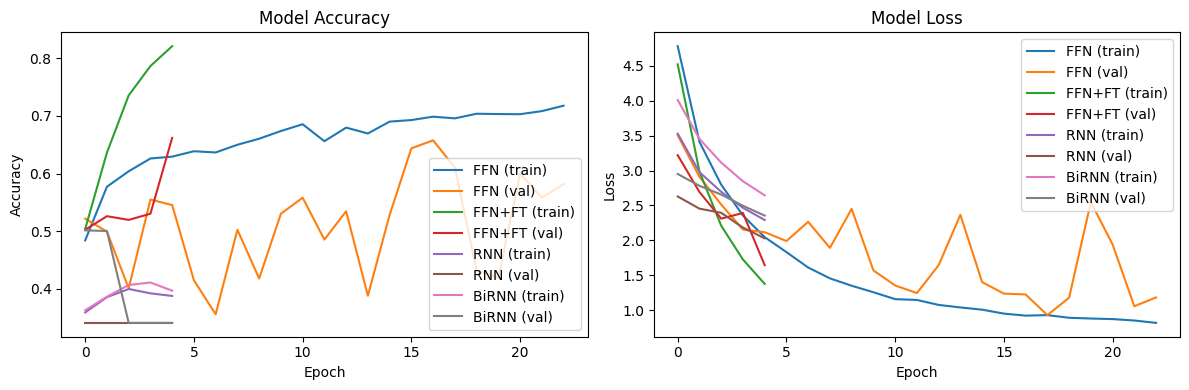


FFN Classification Report:
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.80      0.05      0.09       175
           1       0.61      0.95      0.74       622
           2       0.76      0.39      0.52       372

    accuracy                           0.63      1169
   macro avg       0.72      0.46      0.45      1169
weighted avg       0.69      0.63      0.57      1169


FFN+FT Classification Report:
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       175
           1       0.53      1.00      0.70       622
           2       0.57      0.01      0.02       372

    accuracy                           0.53      1169
   macro avg       0.37      0.34      0.24      1169
weighted avg       0.47      0.53      0.38      1169


RNN Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       175
           1       0.00      0.00      0.00       622
           2       0.32      1.00      0.48       372

    accuracy                           0.32      1169
   macro avg       0.11      0.33      0.16      1169
weighted avg       0.10      0.32      0.15      1169


BiRNN Classification Report:
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       175
           1       0.53      1.00      0.69       622
           2       0.00      0.00      0.00       372

    accuracy                           0.53      1169
   macro avg       0.18      0.33      0.23      1169
weighted avg       0.28      0.53      0.37      1169



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Dense, Dropout, SimpleRNN, Bidirectional,
    BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.regularizers import l2

# First, let's analyze class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Sentiment')
plt.title('Distribution of Sentiment Classes')
plt.show()

# Calculate class weights if needed
class_counts = data['Sentiment'].value_counts()
total_samples = len(data)
class_weights = {
    i: total_samples / (len(class_counts) * count)
    for i, count in enumerate(class_counts)
}
print("Class weights:", class_weights)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Callbacks for all models
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.0001
    )
]

# 1. FFN Classifier with pre-trained embeddings
def create_ffn_model(trainable=False):
    model = Sequential([
        Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_matrix.shape[1],
            input_length=max_length,
            weights=[embedding_matrix],
            trainable=trainable
        ),
        # Flatten the embeddings
        GlobalAveragePooling1D(),
        # First hidden layer
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        # Second hidden layer
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        # Output layer
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train FFN with frozen embeddings
ffn_model = create_ffn_model(trainable=False)
print("\nFFN Model Summary:")
ffn_model.summary()

ffn_history = ffn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights
)

# Evaluate FFN model
ffn_preds = ffn_model.predict(X_test)
ffn_preds_classes = np.argmax(ffn_preds, axis=1)
print("\nFFN Model Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), ffn_preds_classes))

# 2. FFN with fine-tuning embeddings
ffn_ft_model = create_ffn_model(trainable=True)
print("\nFFN Fine-tuning Model Summary:")
ffn_ft_model.summary()

ffn_ft_history = ffn_ft_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights
)

# 3. RNN with FFN Classifier head
def create_rnn_model():
    model = Sequential([
        Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_matrix.shape[1],
            input_length=max_length,
            weights=[embedding_matrix],
            trainable=False
        ),
        # Stacked RNNs
        SimpleRNN(256, return_sequences=True),
        Dropout(0.3),
        SimpleRNN(128, return_sequences=True),
        Dropout(0.3),
        SimpleRNN(64),
        Dropout(0.3),
        # FFN head
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

rnn_model = create_rnn_model()
print("\nRNN Model Summary:")
rnn_model.summary()

rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights
)

# 4. Complex Bidirectional RNN
def create_complex_rnn_model():
    model = Sequential([
        Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_matrix.shape[1],
            input_length=max_length,
            weights=[embedding_matrix],
            trainable=False
        ),
        # Bidirectional RNN layers
        Bidirectional(SimpleRNN(256, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(SimpleRNN(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(SimpleRNN(64)),
        Dropout(0.3),
        # FFN head
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

complex_rnn_model = create_complex_rnn_model()
print("\nComplex RNN Model Summary:")
complex_rnn_model.summary()

complex_rnn_history = complex_rnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights
)

# Plot training histories
def plot_training_history(histories, model_names):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} (train)')
        plt.plot(history.history['val_accuracy'], label=f'{name} (val)')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} (train)')
        plt.plot(history.history['val_loss'], label=f'{name} (val)')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training histories for all models
histories = [ffn_history, ffn_ft_history, rnn_history, complex_rnn_history]
model_names = ['FFN', 'FFN+FT', 'RNN', 'BiRNN']
plot_training_history(histories, model_names)

# Evaluate all models and print classification reports
models = {
    'FFN': ffn_model,
    'FFN+FT': ffn_ft_model,
    'RNN': rnn_model,
    'BiRNN': complex_rnn_model
}

for name, model in models.items():
    print(f"\n{name} Classification Report:")
    preds = model.predict(X_test)
    preds_classes = np.argmax(preds, axis=1)
    print(classification_report(np.argmax(y_test, axis=1), preds_classes))